# Deep Deterministic Policy Gradient for Portfolio Management

In [1]:

import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
import matplotlib
# for compatible with python 3
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
import pandas as pd
import h5py
abbreviation  = list(pd.read_csv('utils/datasets/stock_table.csv')['code'].values)

filepath='utils/datasets/stock_history.h5'
with h5py.File(filepath, 'r') as f:
    history = f['history'][:]


In [5]:
history.shape

(19, 1377, 5)

In [4]:
# read the data and choose the target stocks for training a toy example
#history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
num_training_time = history.shape[1]
num_testing_time = history.shape[1]
window_length = 3

In [12]:
num_training_time

1377

In [5]:
# dataset for 16 stocks by splitting timestamp
#history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
import pandas as pd
import h5py
abbreviation  = list(pd.read_csv('utils/datasets/stock_table.csv')['code'].values)

filepath='utils/datasets/stock_history.h5'
with h5py.File(filepath, 'r') as f:
    history = f['history'][:]

    
history = history[:, :, :4]

# 16 stocks are all involved. We choose first 3 years as training data
num_training_time = 977
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [6]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(19, 977, 4)
(19, 400, 4)


In [7]:
nb_classes

20

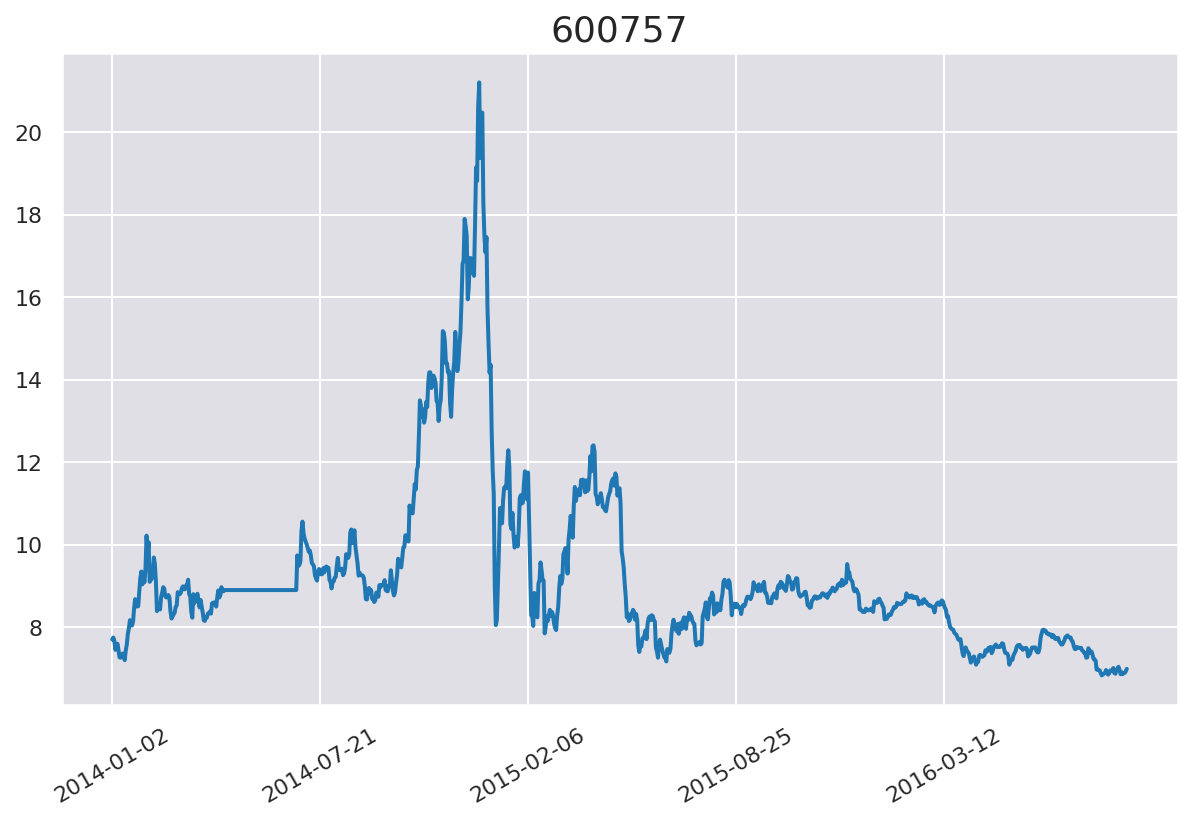

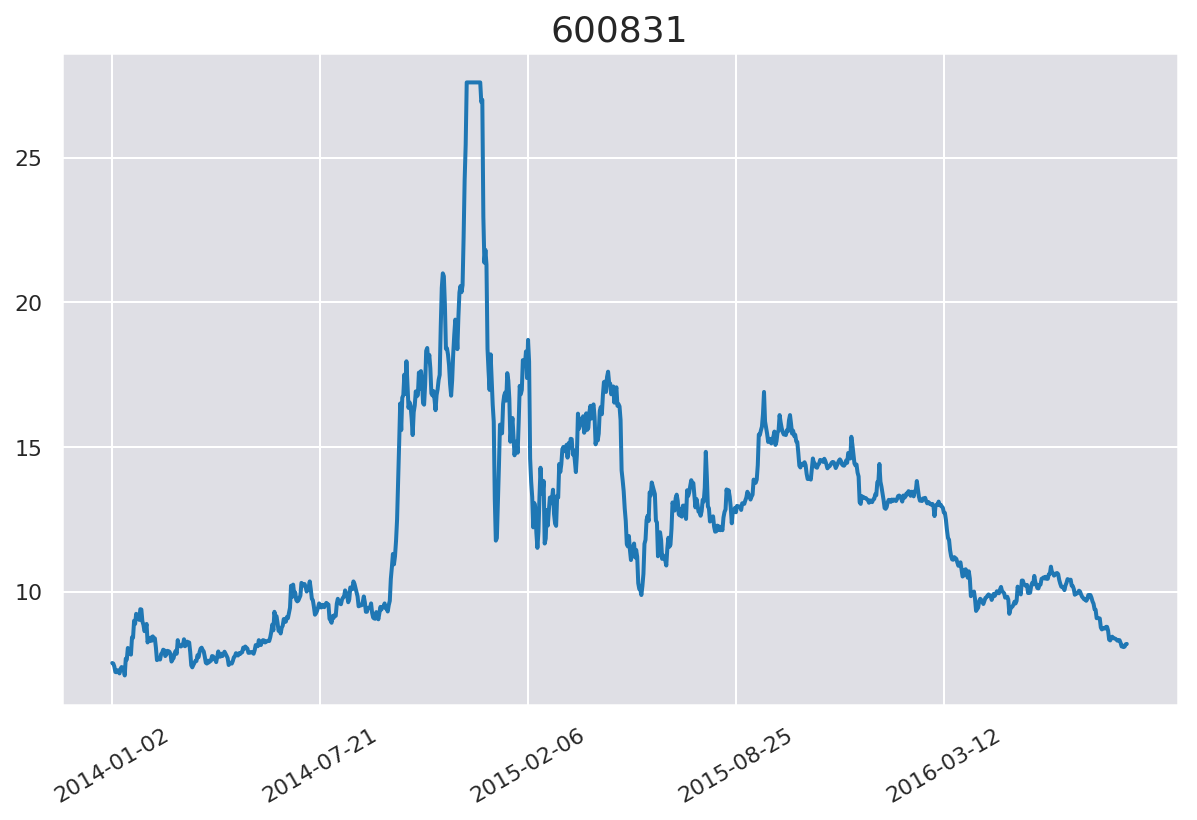

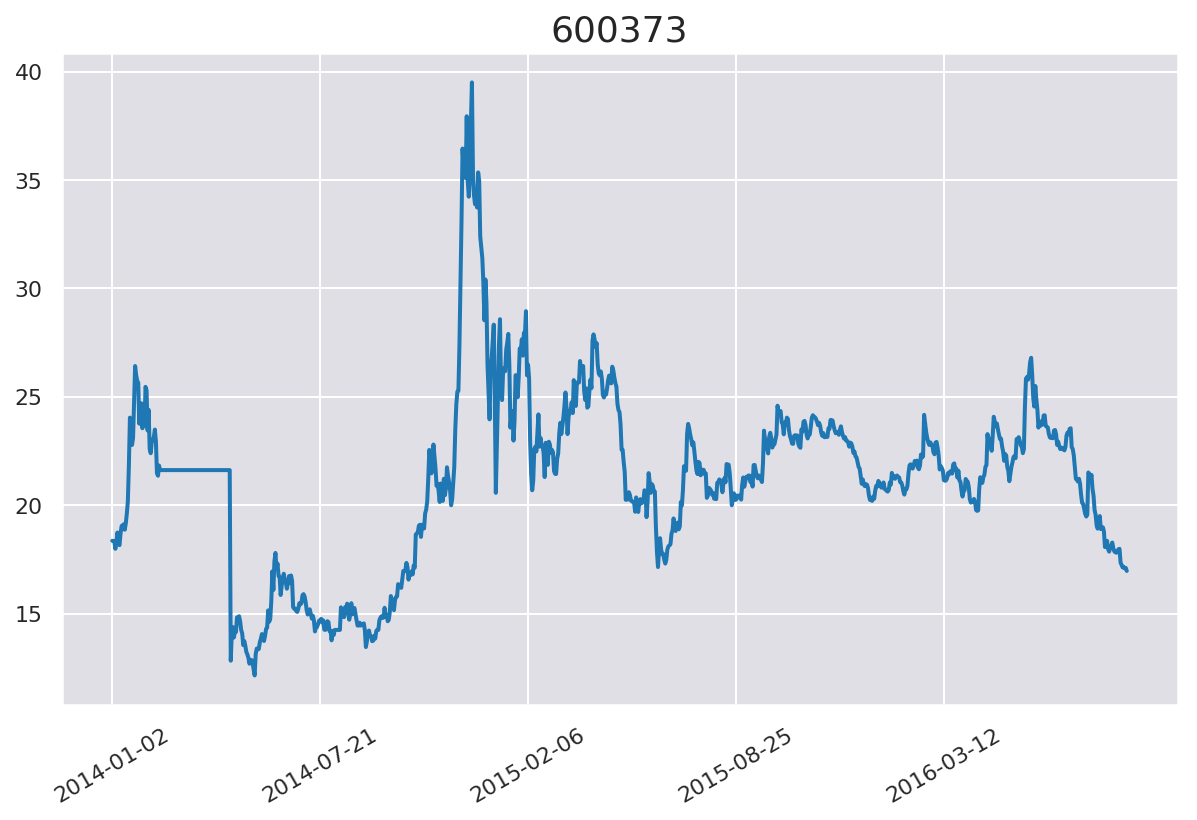

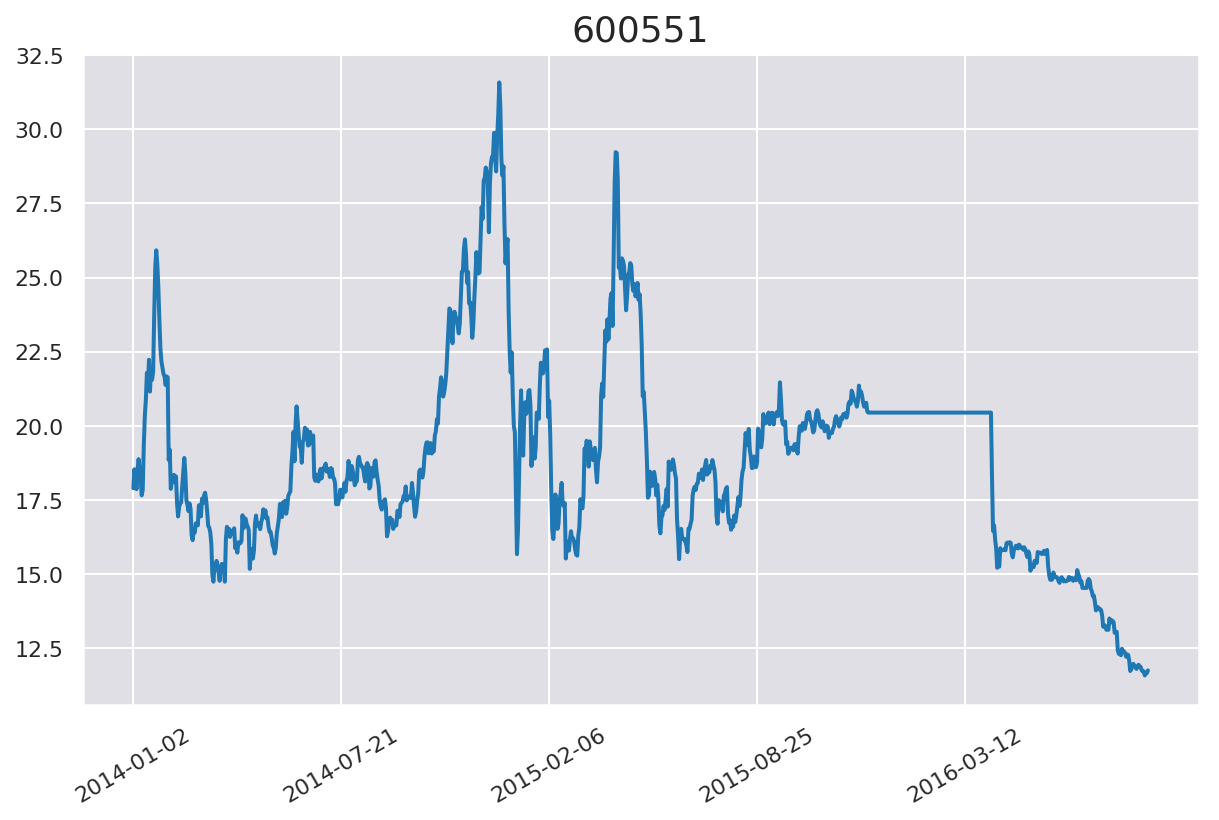

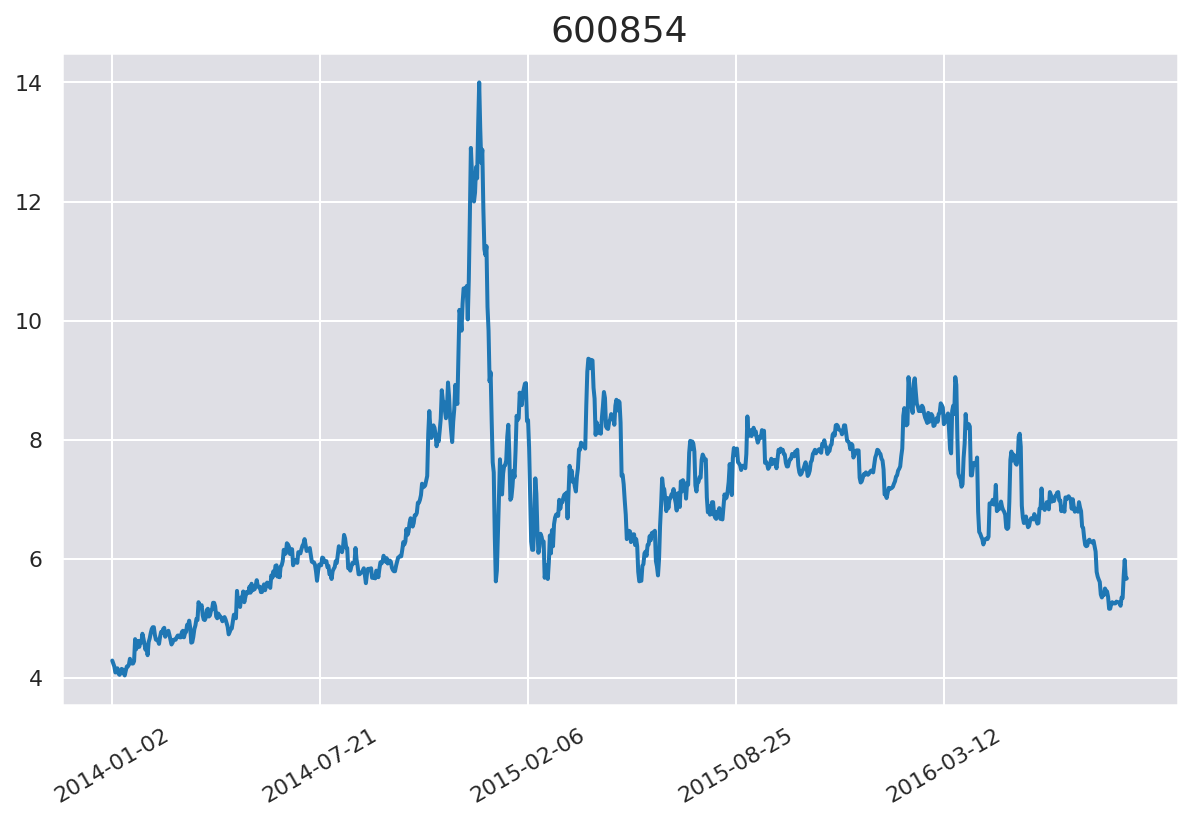

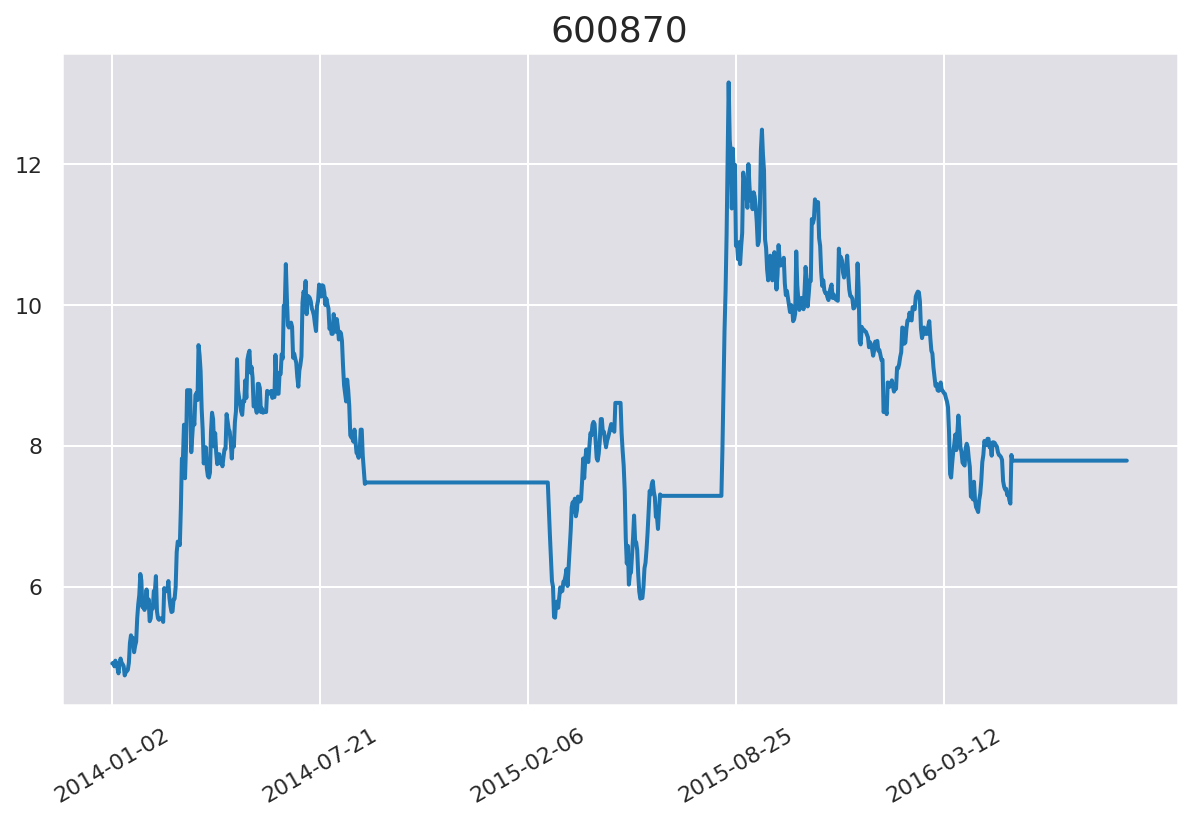

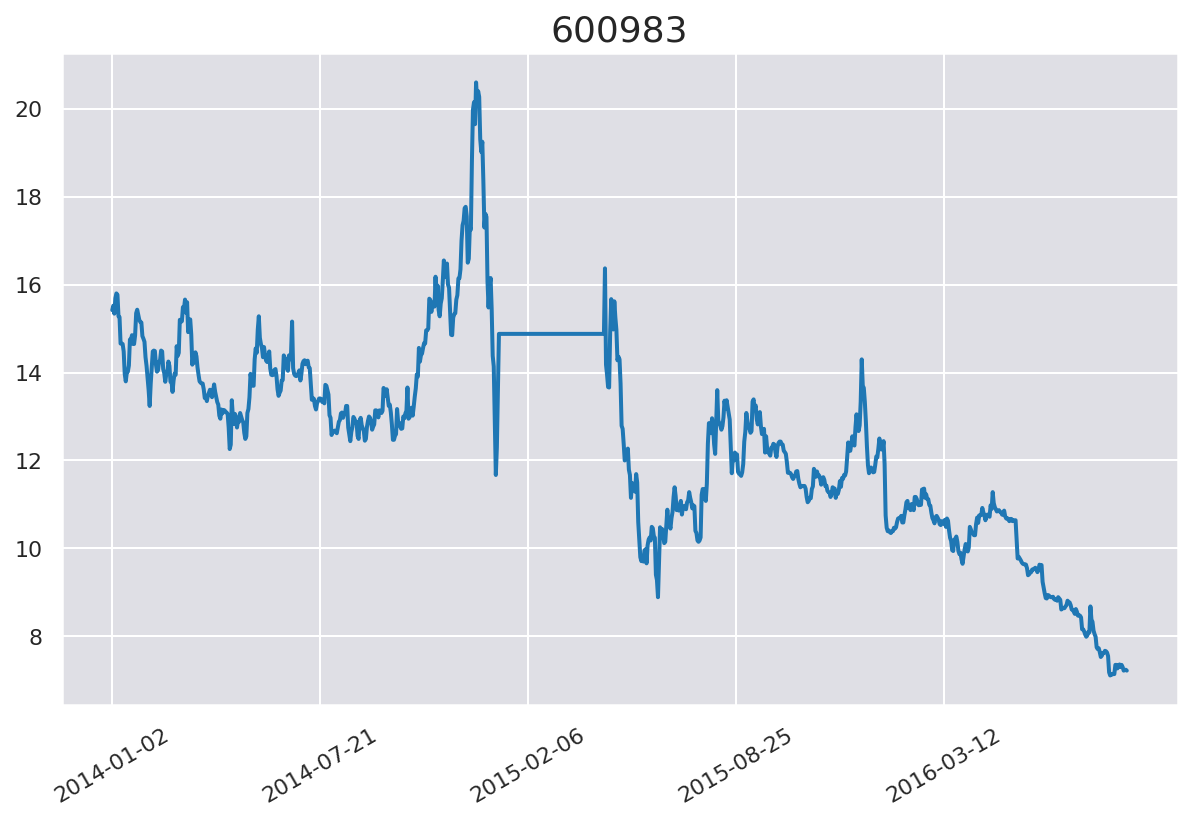

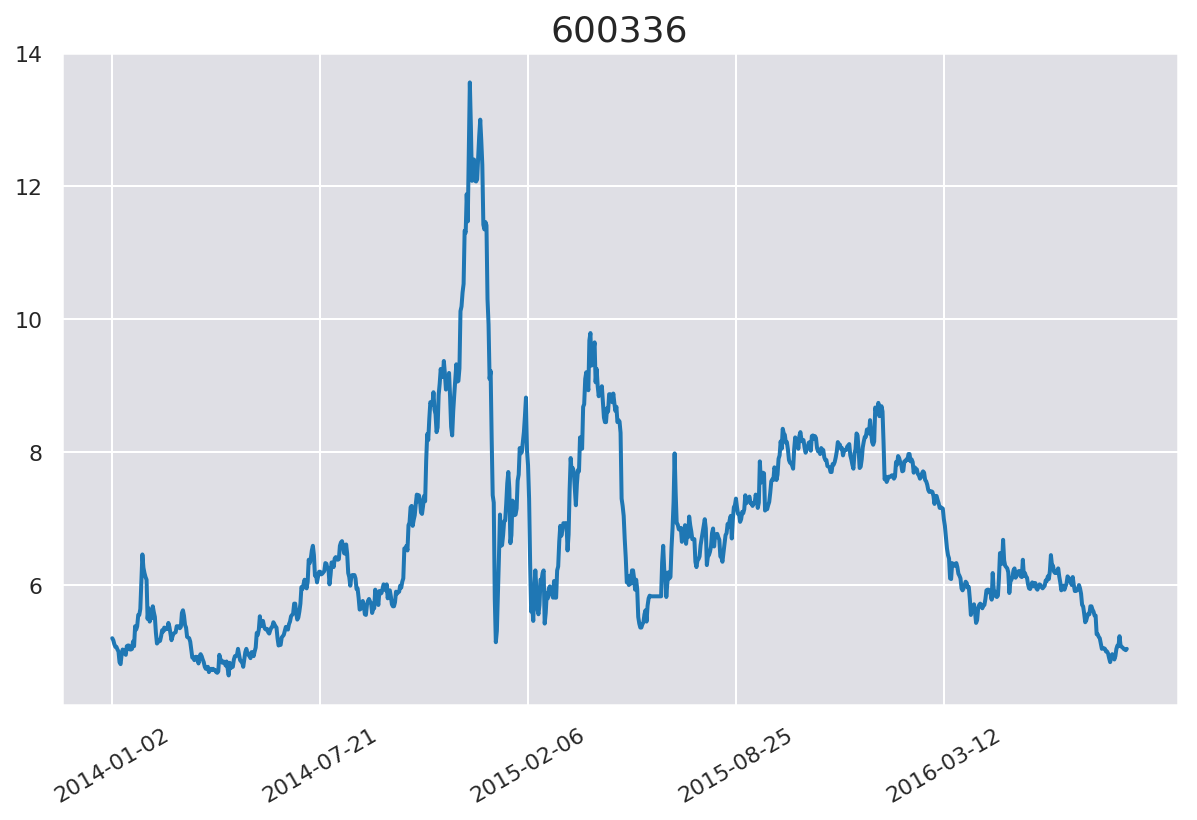

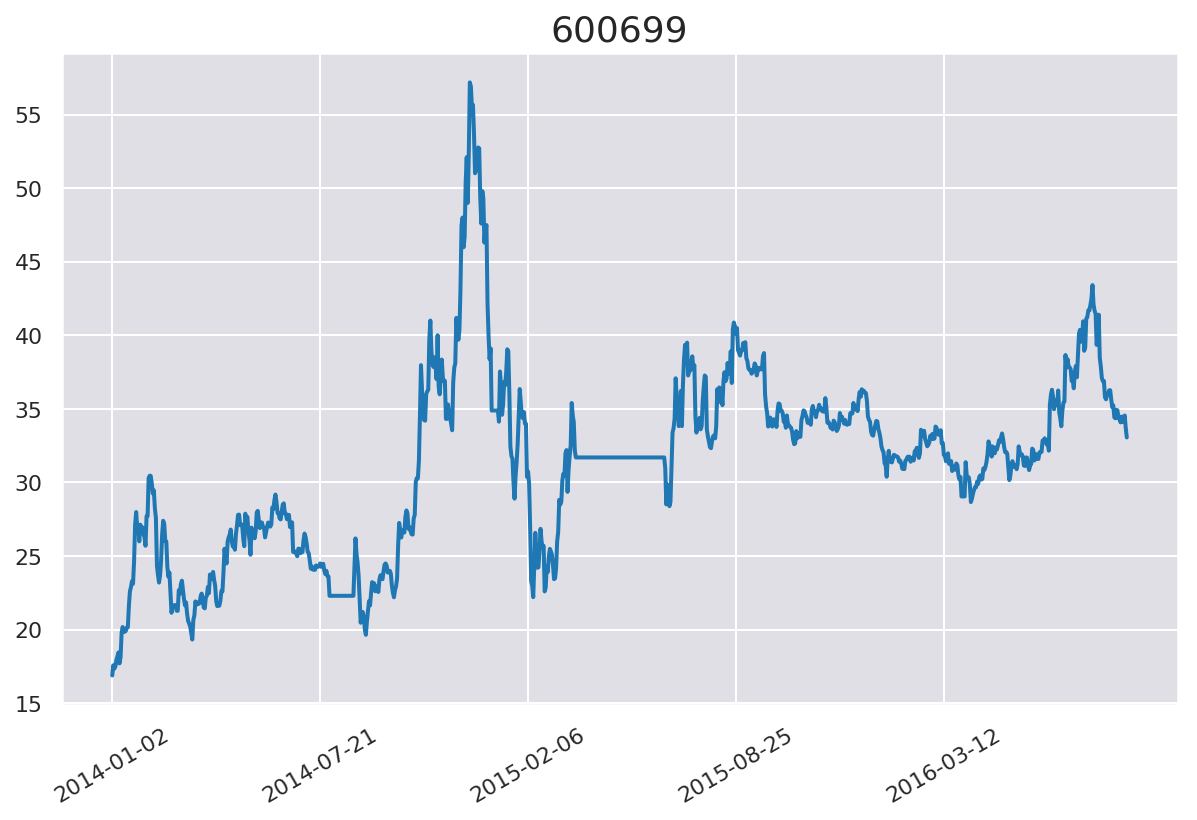

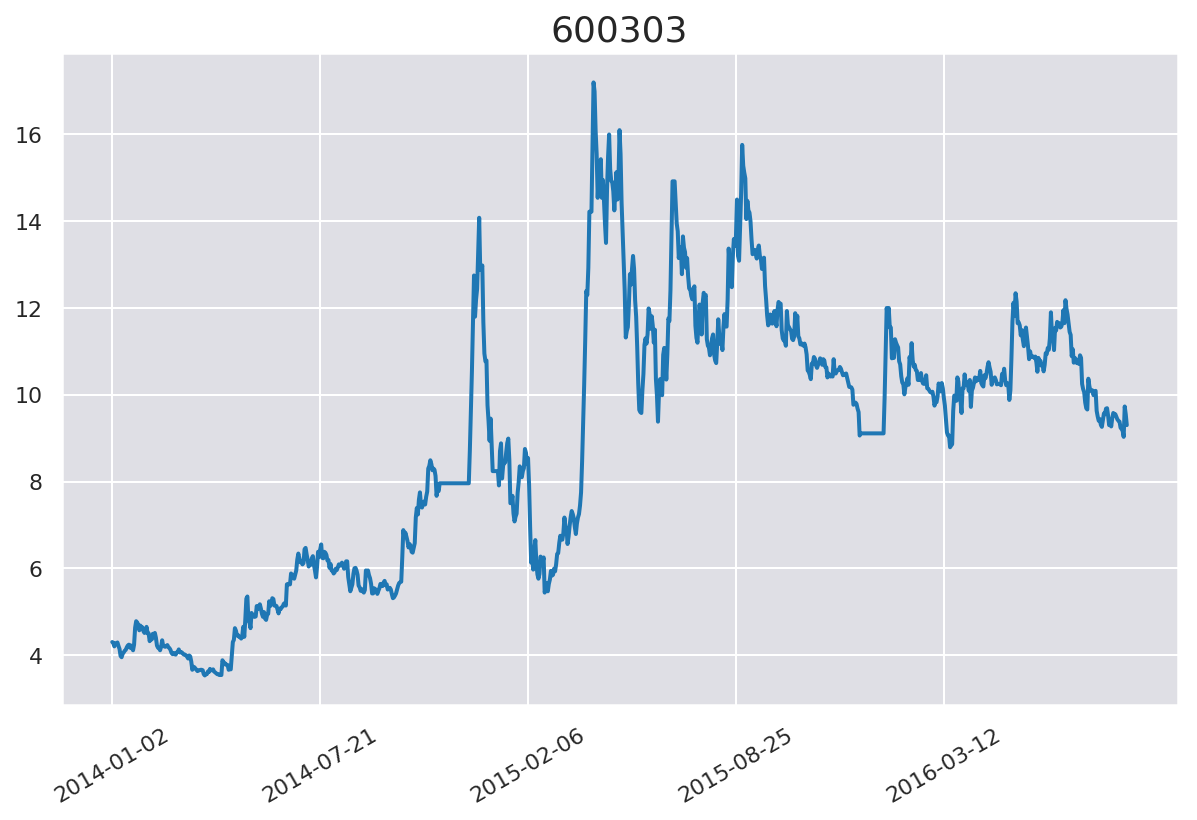

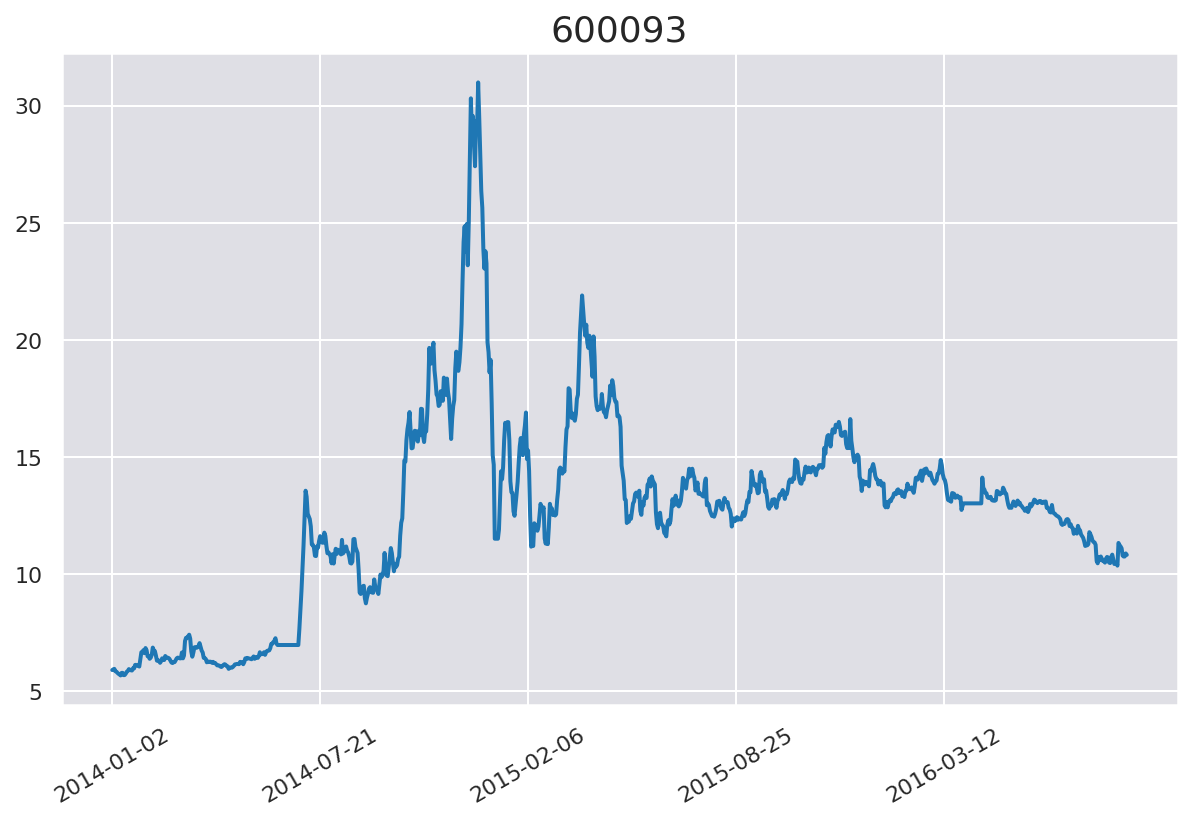

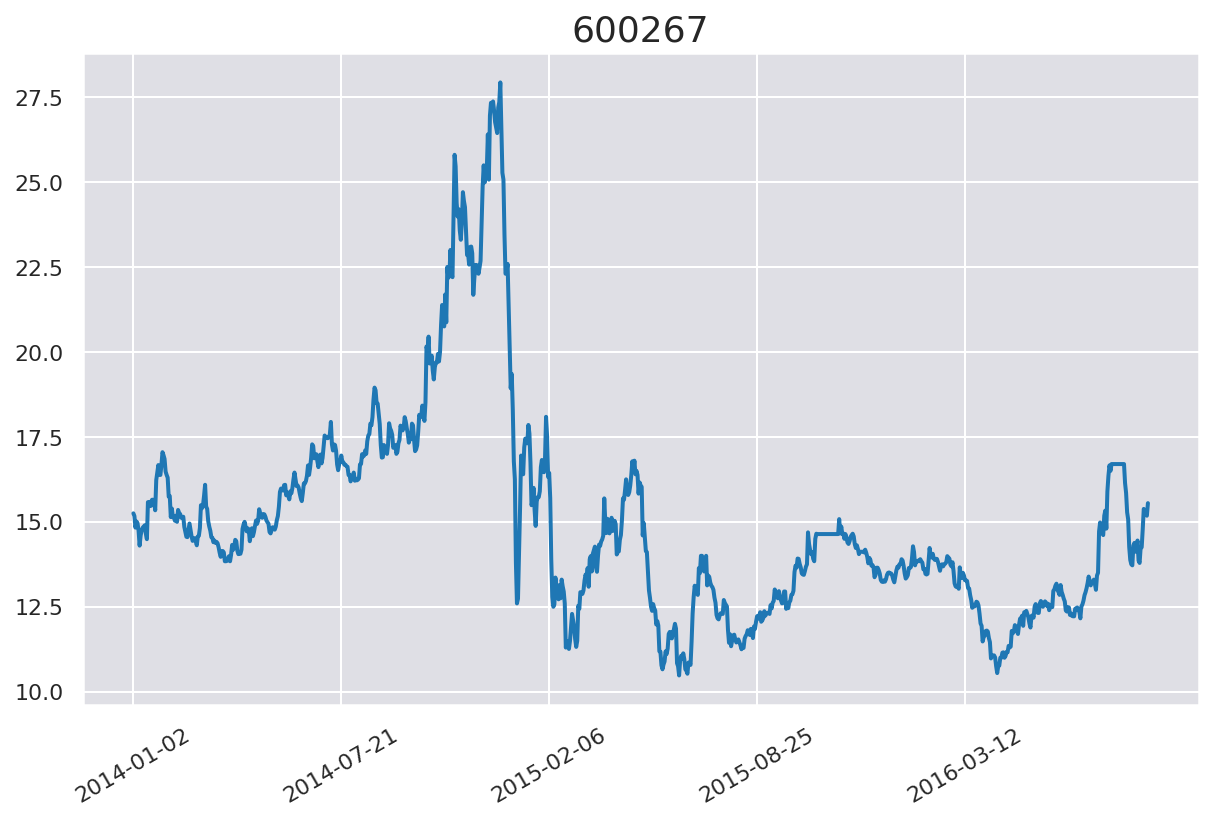

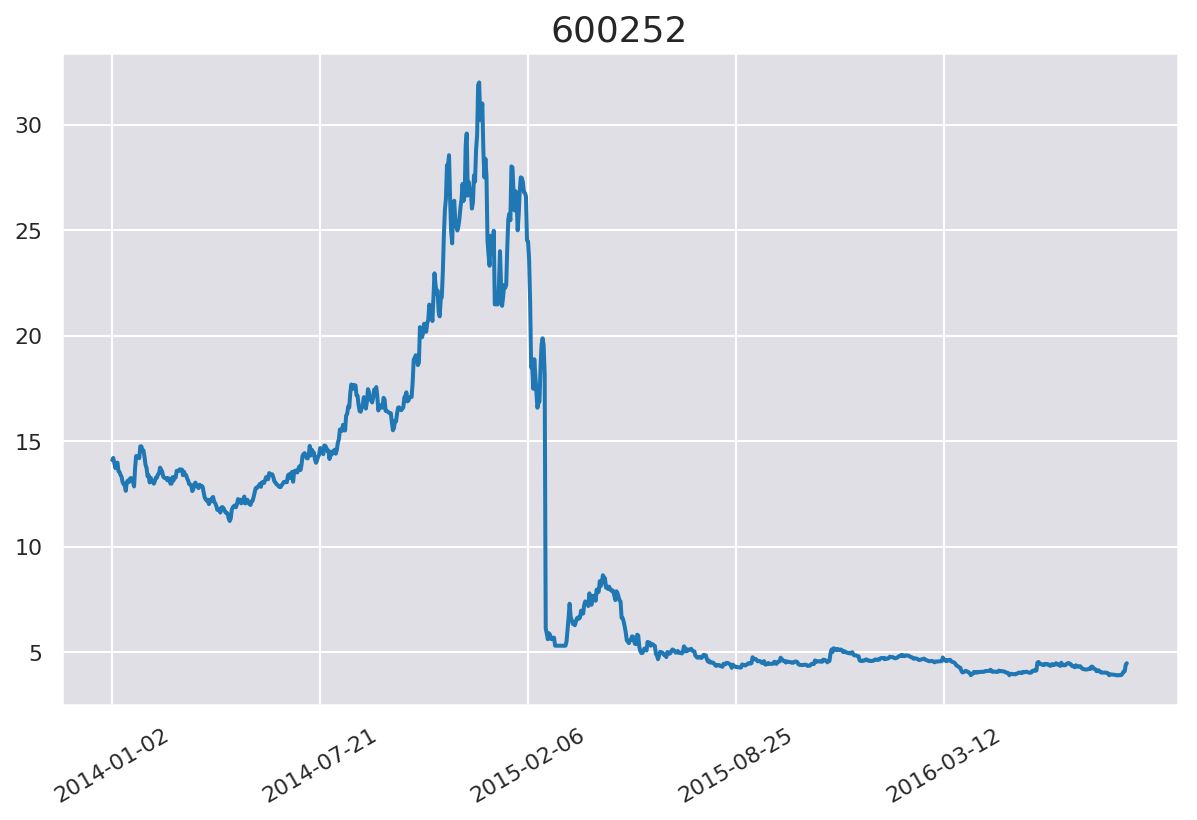

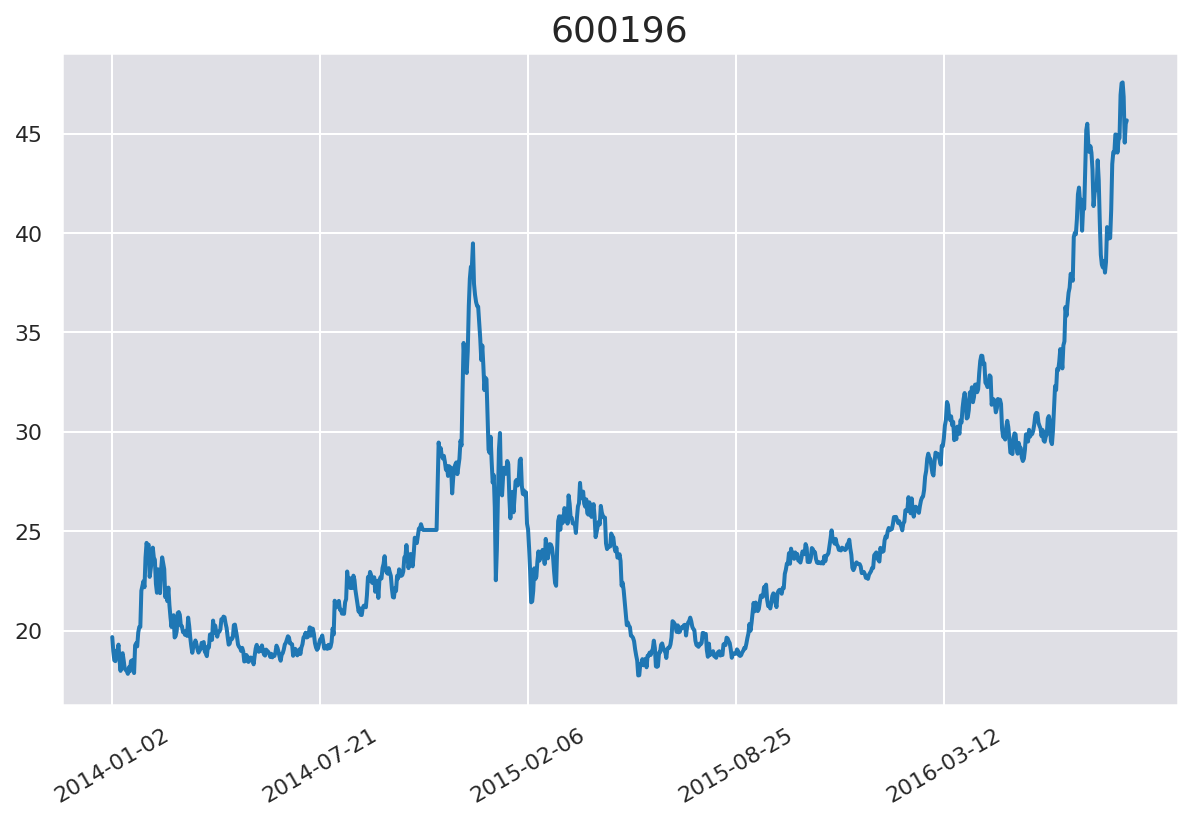

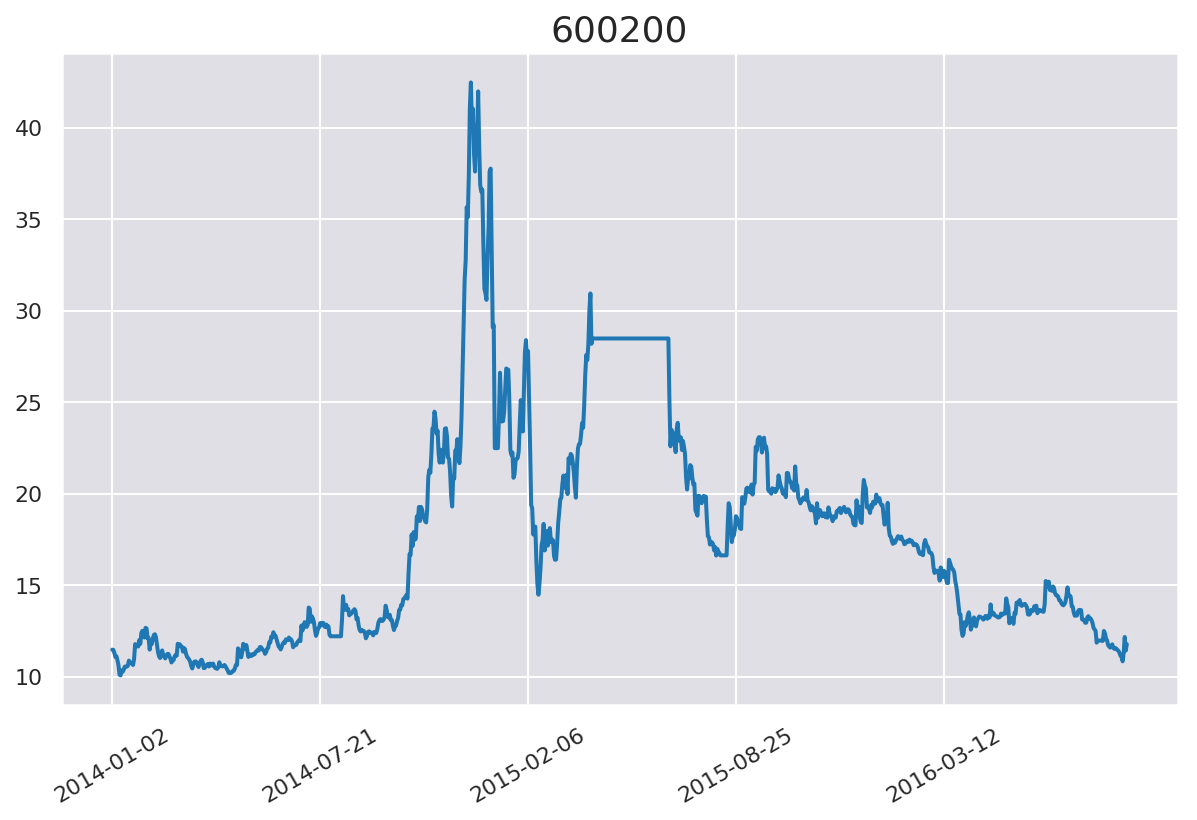

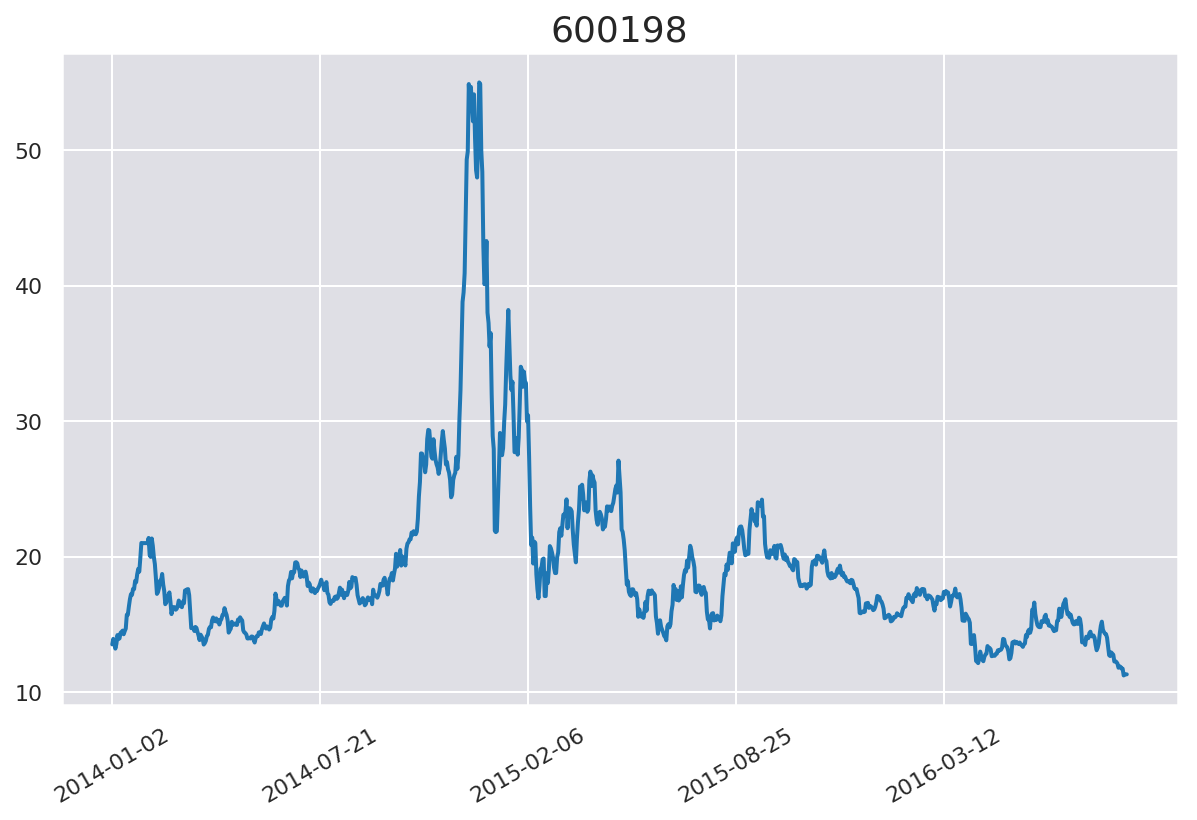

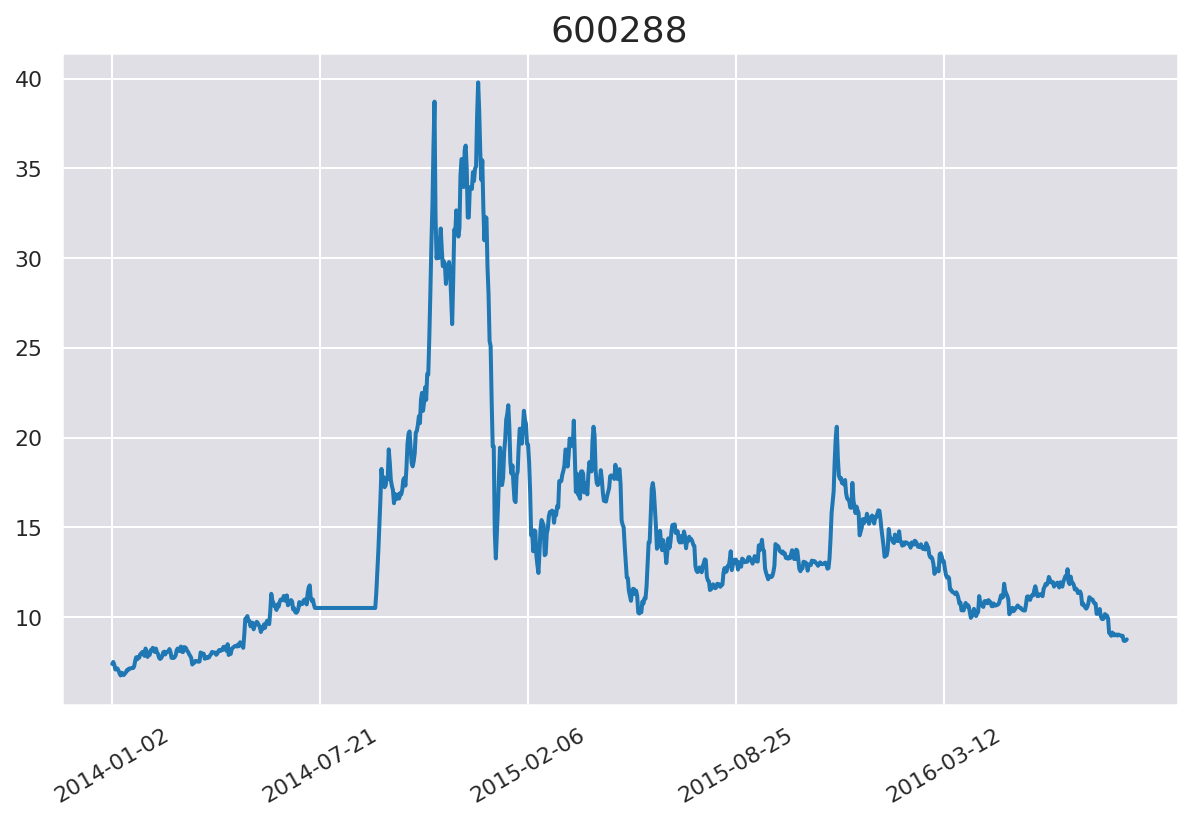

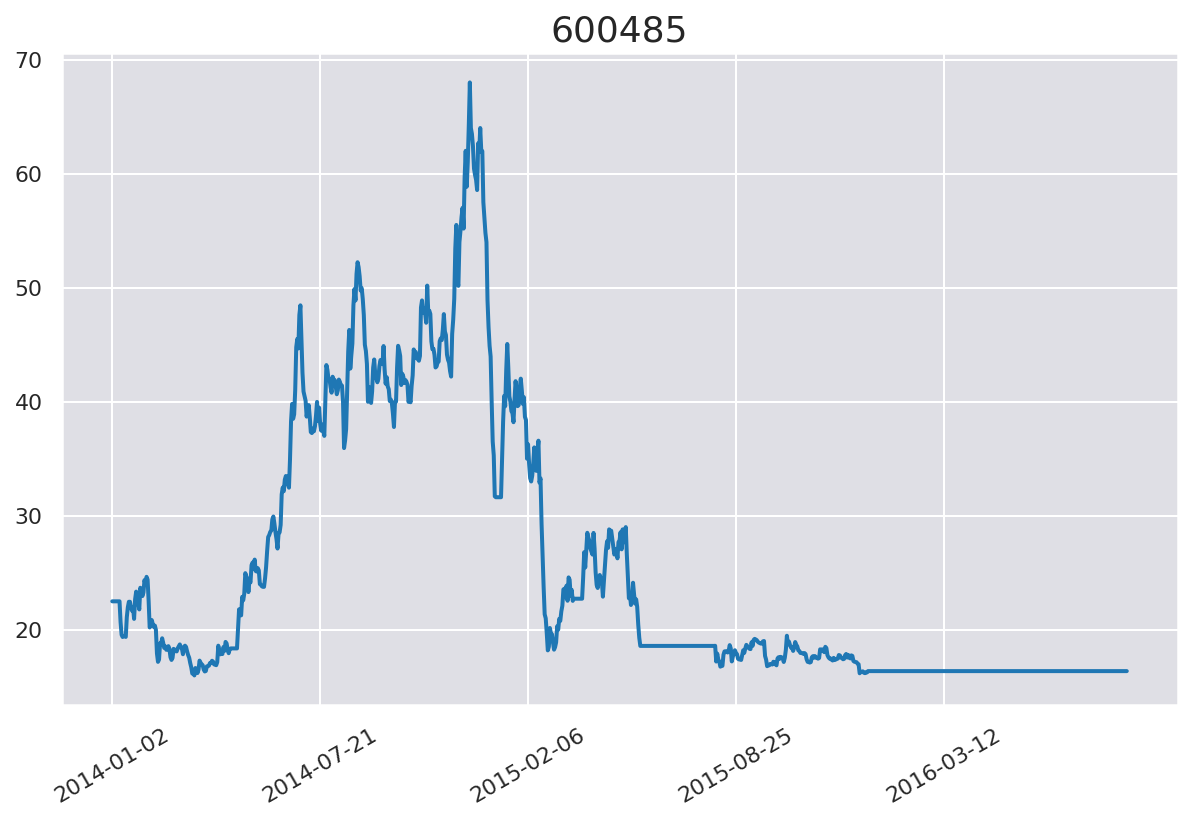

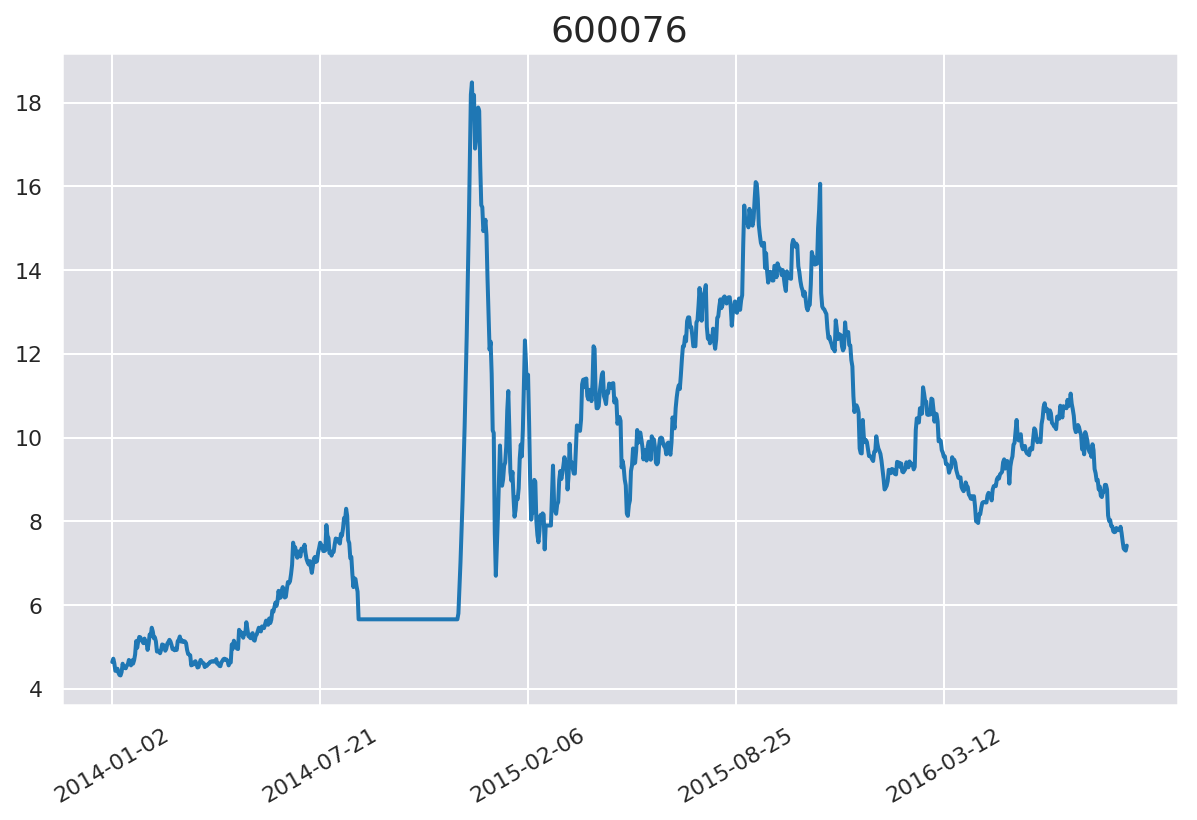

In [16]:
# visualize 3 stock open price
if True:
    date_list = [index_to_date(i) for i in range(target_history.shape[1])]
    x = range(target_history.shape[1])
    for i in range(len(target_stocks)):
        plt.figure(i)
        plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
        plt.xticks(x[::200], date_list[::200], rotation=30)
        plt.title(target_stocks[i])
        plt.show()

## Load Models

In [8]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope, test_model_multiple
    
from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN
from environment.portfolio import *

Using TensorFlow backend.


In [9]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [10]:
models = []
model_names = []
window_length_lst = [3,7]
predictor_type_lst = ['lstm']

#window_length_lst = [3, 7, 14, 21]
#predictor_type_lst = ['cnn', 'lstm']
use_batch_norm = True

In [11]:
# instantiate environment, 3 stocks, with trading cost, window_length 3, start_date sample each time
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)

INFO:tensorflow:Restoring parameters from weights/sse_stock/lstm/window_3/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/sse_stock/lstm/window_7/batch_norm/checkpoint.ckpt


In [12]:
models

In [22]:
testing_history.shape

(19, 400, 4)

/home/lmc/文档/cs277/drl-portfolio-management/src/environment/portfolio.py:46: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  trough = returns[returns.argmax():].min()


<Figure size 720x432 with 0 Axes>

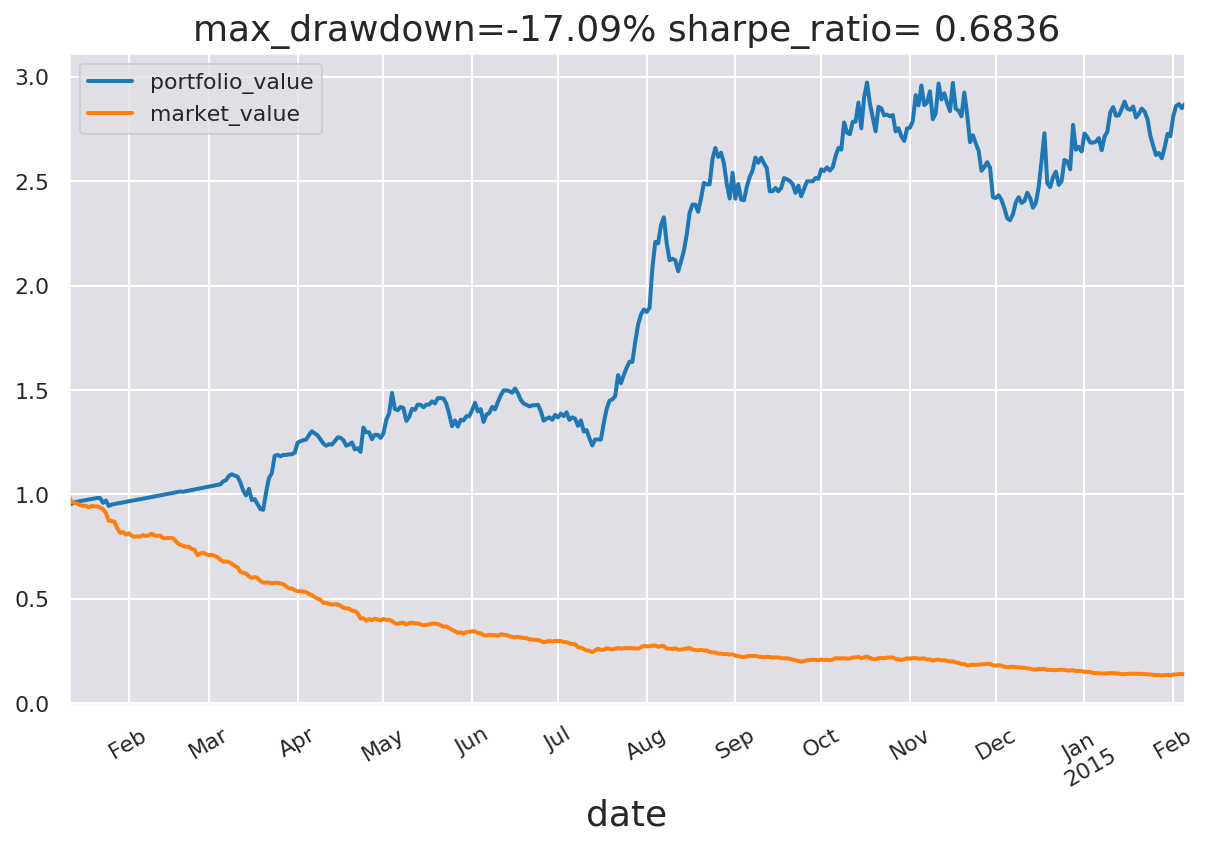

In [13]:
    
env = PortfolioEnv(testing_history, testing_stocks, steps=390, window_length=3)

test_model(env, models[0])

<Figure size 720x432 with 0 Axes>

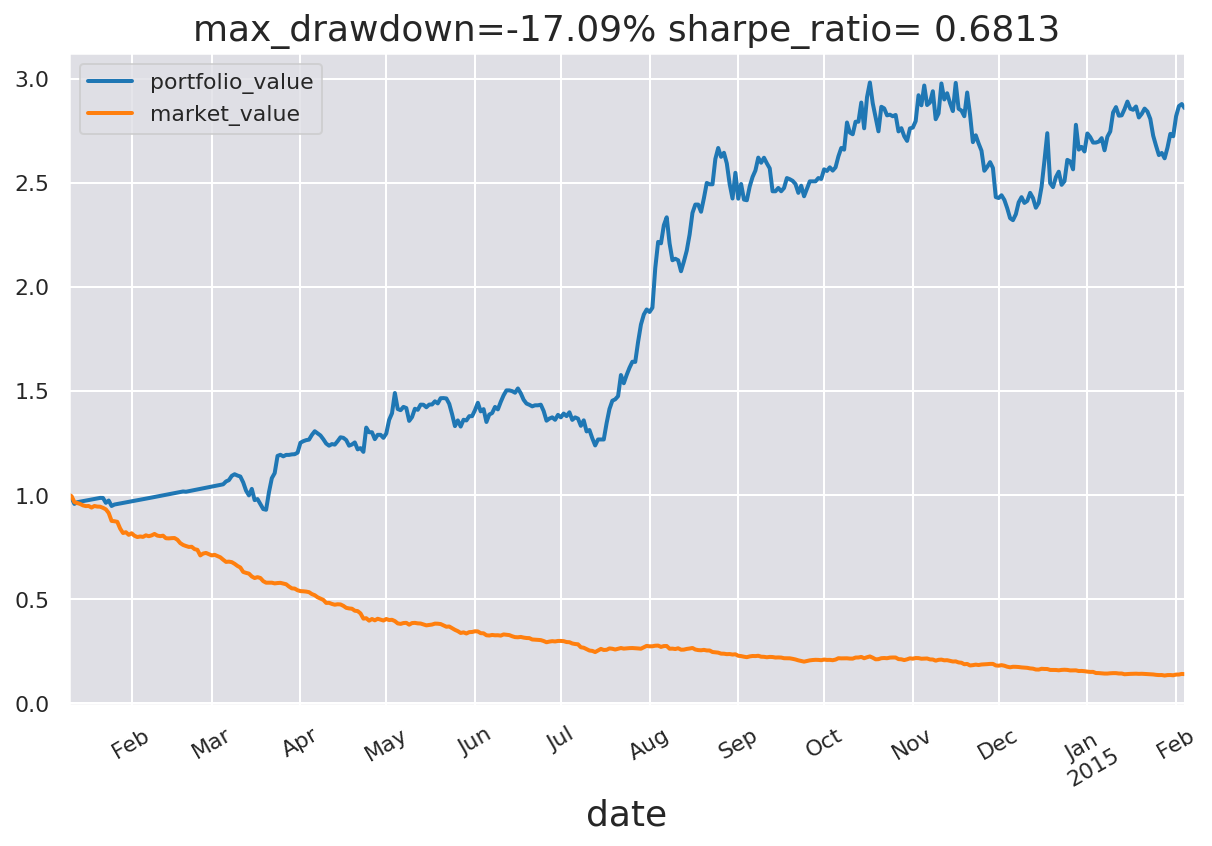

In [19]:
action_list = []
observation, info = env.reset()
done = False
while not done:
    action = models[0].predict_single(observation)
    action_list.append(list(action))
    observation, _, done, info = env.step(action)
    
env.render()

In [14]:
values = []

for each_info in env.infos:
    values.append(each_info['portfolio_value'])

In [15]:
values = np.array(values)

In [20]:
values.argmax()

279

In [17]:
stock_names = ['人民币']
stock_names1  = list(pd.read_csv('utils/datasets/stock_table.csv')['name'].values)
stocks = stock_names + stock_names1

In [18]:
stocks

['人民币',
 '长江传媒',
 '广电网络',
 '中文传媒',
 '时代出版',
 '春兰股份',
 '厦华电子',
 '惠而浦',
 '澳柯玛',
 '均胜电子',
 '曙光股份',
 '易见股份',
 '海正药业',
 '中恒集团',
 '复星医药',
 '江苏吴中',
 '大唐电信',
 '大恒科技',
 '信威集团',
 '康欣新材']

In [22]:
action_df = pd.DataFrame(action_list, columns=stocks)

In [23]:
action_df.to_csv('action_value.csv',index=False)

In [82]:
values = []

for each_info in env.infos:
    values.append([each_info['portfolio_value'],each_info['market_value']])
                   
                   
df_values = pd.DataFrame(values, columns=['portfolio_value','market_value'])
df_values.to_csv('test_win_3_portfolio_value.csv', header=None,index=False)

<Figure size 720x432 with 0 Axes>

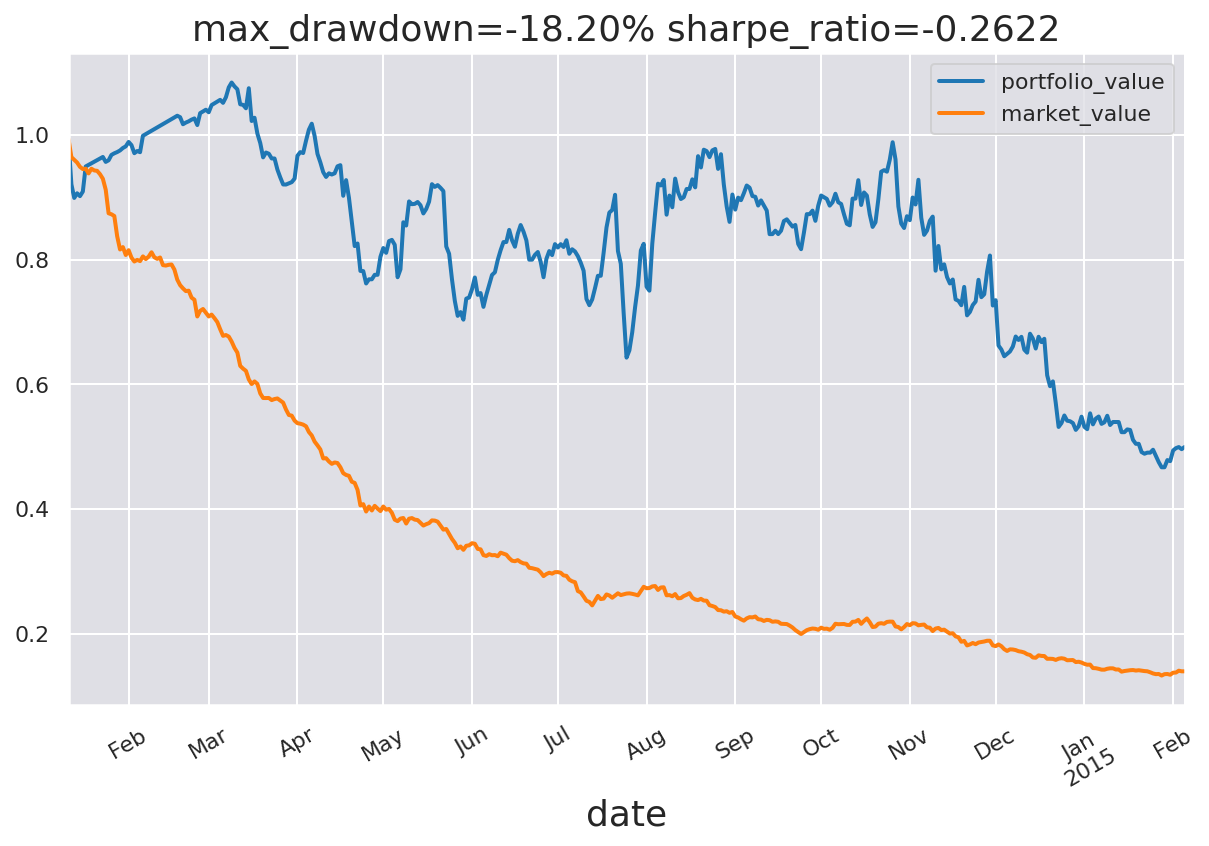

In [83]:
env = PortfolioEnv(testing_history, testing_stocks, steps=390, window_length=7)

test_model(env, models[1])


In [84]:
values = []

for each_info in env.infos:
    values.append([each_info['portfolio_value'],each_info['market_value']])
                   
                   
df_values = pd.DataFrame(values, columns=['portfolio_value','market_value'])
df_values.to_csv('test_win_7_portfolio_value.csv', header=None,index=False)

In [109]:
values = []

for each_info in env.infos:
    values.append([each_info['portfolio_value'],each_info['market_value']])
                   
                   
df_values = pd.DataFrame(values, columns=['portfolio_value','market_value'])
df_values.to_csv('win_7.csv', header=None,index=False)

In [25]:
# test on imitation learning
optimal_given_past_model = create_network_give_past(nb_classes, 3, 
                                        weight_path='weights/stock/imitation_16_stocks.h5')

Model load successfully


In [26]:
env = PortfolioEnv(testing_history, testing_stocks, steps=365, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

/Users/chizhang/Developer/drl-portfolio-management/src/environment/portfolio.py:41: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  trough = returns[returns.argmax():].min()


<Figure size 720x432 with 0 Axes>

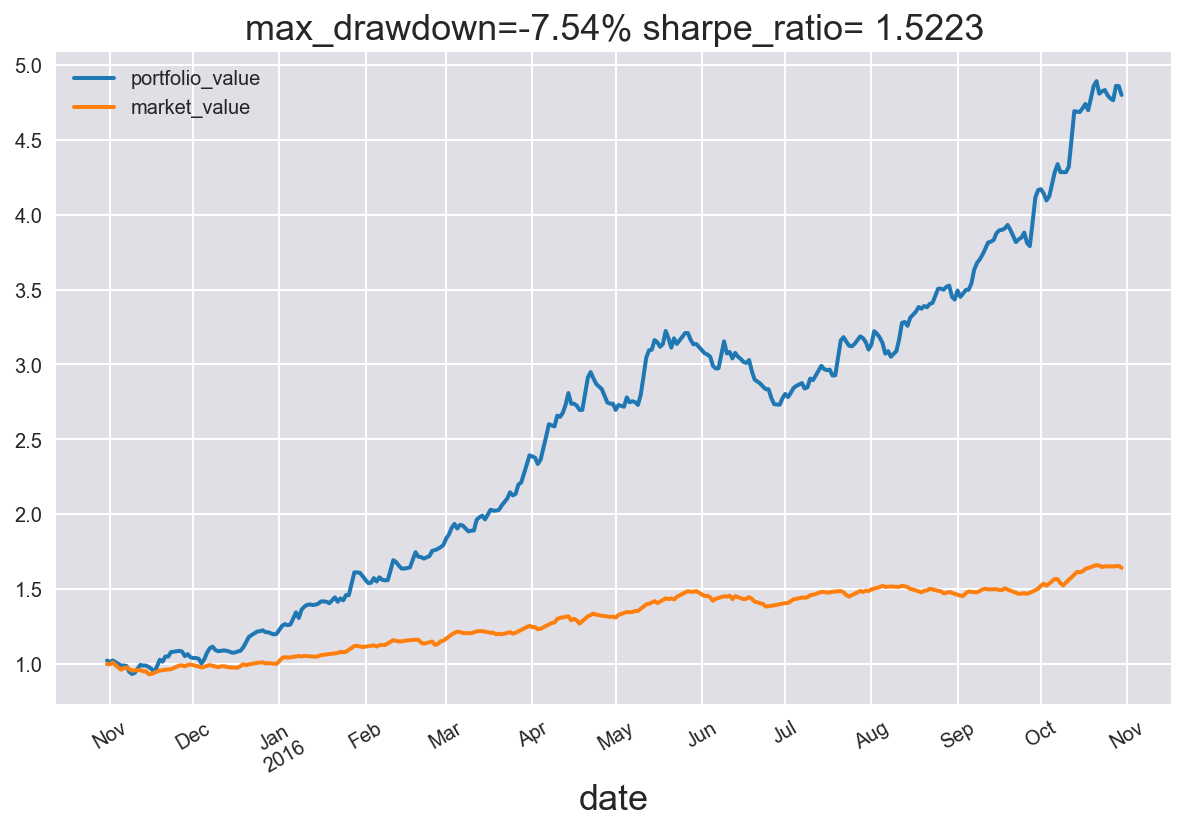

In [27]:
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.zeros((nb_classes,))
    close_open_ratio = close_open_ratio[:, -3:]
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    current_action_index = optimal_given_past_model.predict_classes(close_open_ratio, verbose=False)
    action[current_action_index] = 1.0
    observation, reward, done, _ = env.step(action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
    close_open_ratio = normalize(close_open_ratio)
env.render()